# Test image alignment

## Background

Across the project, the position of the camera varied relative to the arena. This means that tracking data in one session may not be directly comparable to another, because the positions of response ports etc is not constant. To deal with this, we register the images to a common reference image (see registration.py for more info). 

The goal of this notebook is to correct tracking data using the transformation estimated during image registration.

To start with, we need two blocks with tracking data and clearly different camera positions relative to the image.

In [2]:
session_A = {
    'fnum': 1517,
    'block': 'J2-10',
    'calib_im': "2016-09-28 17_32_17.jpg"   
}

session_B = {
    'fnum': 1613,
    'block': 'J2-9',
    'calib_im': "2017-04-10 08_36_10.jpg"   
}

In [3]:
from dotenv import load_dotenv
from pathlib import Path
import os, sys

sys.path.insert(0, str(Path.cwd().parent))      # import local module
from loading import load_parquet
import transform as vtran

load_dotenv()

data_path = Path(os.getenv("local_home")) / 'Task_Switching/head_tracking'

img_path = data_path / 'calibration_images'
align_path = data_path / 'calibration_alignment_intensity'

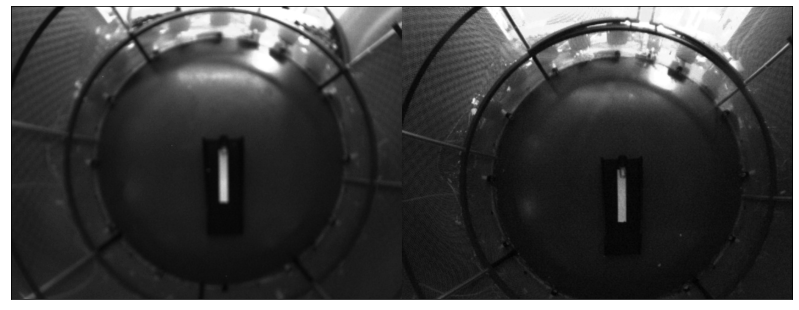

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

calib_img_A = cv2.imread( str(img_path / session_A['calib_im']), cv2.IMREAD_GRAYSCALE)
calib_img_B = cv2.imread( str(img_path / session_B['calib_im']), cv2.IMREAD_GRAYSCALE)


def show_combined_img(img_A, img_B, cmap:str='gray'):

    img_combined = np.concatenate((img_A, img_B), axis=1)

    fig, ax = plt.subplots(1,1, **{'figsize':(14,7)})
    ax.imshow(img_combined, cmap=cmap)
    ax.set_xticks([])
    ax.set_yticks([])

    return ax

show_combined_img(calib_img_A, calib_img_B)
plt.show()

[[  0.98914146  -0.14696668  47.63545227]
 [  0.14696668   0.98914146 -18.80809784]]


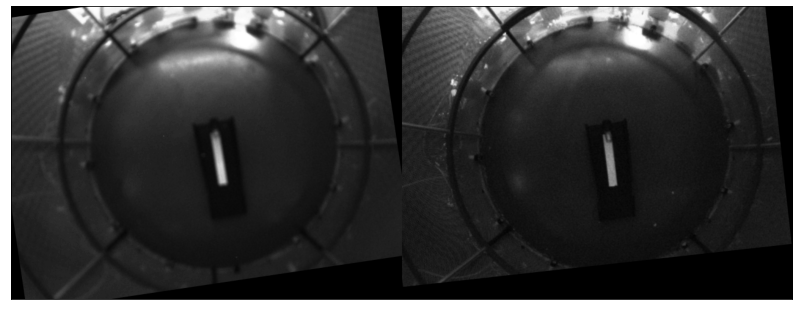

In [5]:
warp_mat_A = np.loadtxt( str(align_path / session_A['calib_im'].replace('.jpg','_warp.txt')))
warp_mat_B = np.loadtxt( str(align_path / session_B['calib_im'].replace('.jpg','_warp.txt')))

def align_image(img, warp_matrix):
    """ Use warpAffine for Translation, Euclidean and Affine 
    
        Note the use of an INVERSE warp mapping
    """
    
    img_size = img.shape
    img_size = (img_size[1], img_size[0])
    return cv2.warpAffine(img, warp_matrix, img_size, flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

align_img_A = align_image(calib_img_A, warp_mat_A)
align_img_B = align_image(calib_img_B, warp_mat_B)

print(warp_mat_A)

show_combined_img(align_img_A, align_img_B)
plt.show()

## Show tracking data before alignmnet

In [6]:
tracking_path = data_path 
tracking_file = 'DLC_combined_230215_1644.parquet'

tracking_A = load_parquet(tracking_path / tracking_file, fnum=session_A['fnum'], block=session_A['block'])
print(f"Loaded {tracking_A.shape[0]} rows for session A (F{session_A['fnum']} Block_{session_A['block']})")

tracking_B = load_parquet(tracking_path / tracking_file, fnum=session_B['fnum'], block=session_B['block'])
print(f"Loaded {tracking_B.shape[0]} rows in session B (F{session_B['fnum']} Block_{session_B['block']})")

Loaded 46354 rows for session A (F1517 Block_J2-10)
Loaded 35844 rows in session B (F1613 Block_J2-9)


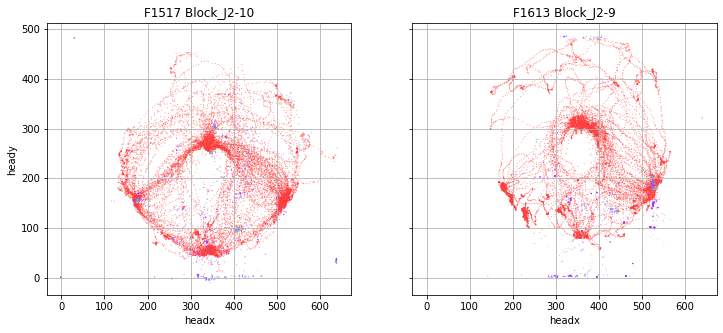

In [7]:
import seaborn as sns
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, **{'figsize':(12,5)})

def plot_head_position(ax, session_df, fnum:int, block:str):

    sns.scatterplot(
        data = session_df,
        x='headx', 
        y="heady", 
        hue="headlikelihood", 
        palette = 'rainbow',
        s = 1,
        ax = ax,
        legend = False,
        alpha = 0.5)


    ax.grid(True)
    ax.set_title(f"F{fnum} Block_{block}")
    ax.invert_yaxis()

plot_head_position(axs[0], tracking_A, fnum=session_A['fnum'], block=session_A['block'])
plot_head_position(axs[1], tracking_B, fnum=session_B['fnum'], block=session_B['block'])

plt.show()

Construct 2D histograms of head position - this gives us an image comparable to the calibration image, for which we can then see the effects of image correction

In [8]:
# def get_head_position_heatmap(df, h=480, w=640, step_size:float=50, likelihood_threshold:float=0.6):

#     idx = df[df['headlikelihood'] > likelihood_threshold].index
#     xy = df.loc[idx, ['headx','heady']]

#     xy = xy[(xy['headx']>=0) & (xy['heady']>=0)]
#     xy = xy[(xy['headx']<w) & (xy['heady']<h)]

#     hm_img = np.zeros((h, w), dtype=np.uint8)

#     for i, xy_i in xy.iterrows():
#         hm_img[int(xy_i.heady), int(xy_i.headx)] += step_size

#     return hm_img

# hm_img_A = get_head_position_heatmap(tracking_A)
# hm_img_B = get_head_position_heatmap(tracking_B)

# align_hm_A = align_image(hm_img_A, warp_mat_A)
# align_hm_B = align_image(hm_img_B, warp_mat_B)

# show_combined_img(hm_img_A, hm_img_B, cmap='gray')
# plt.title('Before Alignment')

# show_combined_img(align_hm_A, align_hm_B, cmap='gray')
# plt.title('After Alignment')
# plt.show()

## Point transformation

Rather than mapping a whole image, we really want to transform point data about landmarks in the image. We have a function that allows us to do that as part of the transform module for head tracking (loaded at the start of the notebook). 

Let's see how that function performs when plotting the positions of the head before and after using the alignment method.

In [9]:
# The code for transforming landmarks is optimized for pandas data frames and so the code below looks a bit like overkill for individual blocks

# Create copies of data frames 
dlc_A_aligned = tracking_A.copy()
dlc_B_aligned = tracking_B.copy()

# To transform points, we need to manually invert the matrix (as opencv isn't used for point data)
warp_inv_A = vtran.invert_affine_warp(warp_mat_A.copy())
warp_inv_B = vtran.invert_affine_warp(warp_mat_B.copy())

# Align
vtran.transform_positions_in_dataframe(dlc_A_aligned, warp_inv_A, dlc_A_aligned.index)
vtran.transform_positions_in_dataframe(dlc_B_aligned, warp_inv_B, dlc_B_aligned.index)

In [10]:
print(session_A)
print(warp_mat_A)
print(warp_inv_A)

{'fnum': 1517, 'block': 'J2-10', 'calib_im': '2016-09-28 17_32_17.jpg'}
[[  0.98914146  -0.14696668  47.63545227]
 [  0.14696668   0.98914146 -18.80809784]]
[[  1.01097774   0.14696668 -47.63545227]
 [ -0.14696668   1.01097774  18.80809784]]


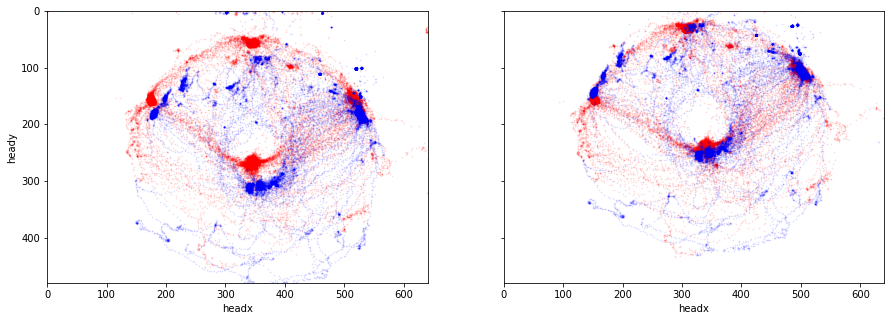

In [11]:
# Draw scatterplots showing point datas before and after alignment
fig, axs = plt.subplots(1,2, **{"figsize":(15,5)}, sharex=True, sharey=True)
alpha = 0.1
size = 0.5

tracking_A.plot.scatter(x='headx',y='heady', c='r', s=size, alpha=alpha, ax=axs[0]) # before
tracking_B.plot.scatter(x='headx',y='heady', c='b', s=size, alpha=alpha, ax=axs[0])

dlc_A_aligned.plot.scatter(x='headx',y='heady', c='r', s=size, alpha=alpha, ax=axs[1]) # after
dlc_B_aligned.plot.scatter(x='headx',y='heady', c='b', s=size, alpha=alpha, ax=axs[1])

for ax in axs:
    ax.set_xlim((0, 640))
    ax.set_ylim((0, 480))
    ax.invert_yaxis()

plt.show()

## Batch processed data

The work above shows the results of processing in the notebook, however for all sessions in the project we need a batch script to run through every session: [time_and_map_tracking.py](./../time_and_map_tracking.py)

Let's now examine the results of this process to check that the script is doing something useful.

In [12]:
dlc_path = data_path / 'DLC_aligned_230216_1732.parquet'

processed_A = load_parquet(dlc_path, fnum=session_A['fnum'], block=session_A['block'])
print(f"Loaded {processed_A.shape[0]} rows for session A (F{session_A['fnum']} Block_{session_A['block']})")

processed_B = load_parquet(dlc_path, fnum=session_B['fnum'], block=session_B['block'])
print(f"Loaded {processed_B.shape[0]} rows in session B (F{session_B['fnum']} Block_{session_B['block']})")

Loaded 46354 rows for session A (F1517 Block_J2-10)
Loaded 35844 rows in session B (F1613 Block_J2-9)


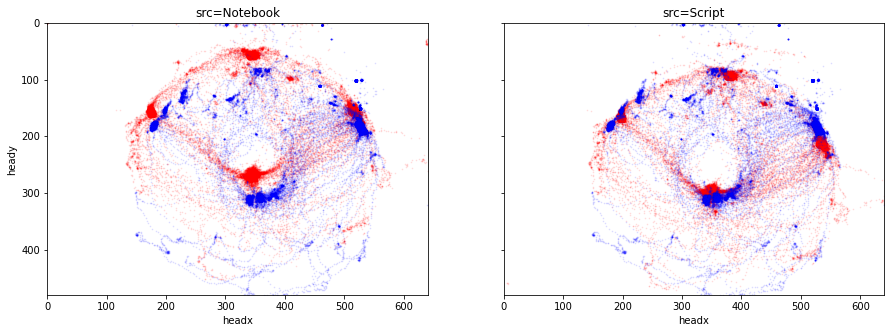

In [13]:
fig, axs = plt.subplots(1,2, **{"figsize":(15,5)}, sharex=True, sharey=True)
alpha = 0.1
size = 0.5

# Show original point data as computed using notebook code in earlier parts of this document
tracking_A.plot.scatter(x='headx',y='heady', c='r', s=size, alpha=alpha, ax=axs[0])
tracking_B.plot.scatter(x='headx',y='heady', c='b', s=size, alpha=alpha, ax=axs[0])
axs[0].set_title('src=Notebook')

# Show point data after alignmnet
# tracking_A.plot.scatter(x='headx',y='heady', c='g', s=size, alpha=alpha, ax=axs[1])
processed_A.plot.scatter(x='headx',y='heady', c='r', s=size, alpha=alpha, ax=axs[1])
processed_B.plot.scatter(x='headx',y='heady', c='b', s=size, alpha=alpha, ax=axs[1])
axs[1].set_title('src=Script')

for ax in axs:
    ax.set_xlim((0, 640))
    ax.set_ylim((0, 480))
    ax.invert_yaxis()

plt.show()

## Looking at webcam vs RV2 camera

The above checks are performed on two videos recorded using the same (RV2) camera, but a bigger challenge comes when aligning data from webcam and RV2... let's find an example to test that.

In [14]:
sys.path.insert(0, str(Path.cwd().parent.parent.parent))
from lib import utils

query = """ 
    SELECT 
        session_dt as datetime, ferret as fnum,	block, video_file, calib_image,
        rotation_matrix_11 as r11,
        rotation_matrix_12 as r12,
        rotation_matrix_21 as r21,
        rotation_matrix_22 as r22,
        translation_column as tx,
        translation_row as ty
    FROM task_switch.video_calib_images vc
    INNER JOIN task_switch.calibration_images ci
        ON vc.calib_image = ci.id
    INNER JOIN task_switch.video_files vf
        ON vc.video_file = vf.filename
    ORDER BY datetime;
"""

vid_files = (
    utils.query_postgres(query)
    .drop_duplicates()
    .reset_index(drop=True)
)

vid_files.head()

,datetime,fnum,block,video_file,calib_image,r11,r12,r21,r22,tx,ty
0,2016-03-23 09:26:30.438,1506,J1-17,F1506_Phoenix_Block_J1-17_Vid0.avi,2016-03-22 15_02_38.jpg,0.999075,-0.043004,0.043004,0.999075,13.151508,-0.254060
1,2016-03-23 17:44:56.668,1506,J1-19,F1506_Phoenix_Block_J1-19_Vid0.avi,2016-03-23 10_54_54.jpg,0.999045,-0.043689,0.043689,0.999045,13.251934,-3.093666
2,2016-03-24 09:05:20.391,1506,J1-20,F1506_Phoenix_Block_J1-20_Vid0.avi,2016-03-23 18_45_59.jpg,0.998792,-0.049134,0.049134,0.998792,14.564552,-4.635597
3,2016-03-25 10:23:58.279,1506,J1-27,F1506_Phoenix_Block_J1-27_Vid0.avi,2016-03-24 15_26_07.jpg,0.999061,-0.043321,0.043321,0.999061,12.760509,-3.022926
4,2016-03-25 16:18:59.372,1506,J1-28,F1506_Phoenix_Block_J1-28_Vid0.avi,2016-03-25 11_59_42.jpg,0.998930,-0.046245,0.046245,0.998930,10.788047,-3.597386


In [15]:
def create_warp_mat(session:dict) -> np.array:
    """ Structure metadata in a way we can use to correct images """
    return np.array([
        [session['r11'], session['r12'], session['tx']], 
        [session['r21'], session['r22'], session['ty']]])


def overlaid_scatter(dlc_x, dlc_y, ax, landmark:str='head', size:float=0.5, alpha:float=0.1):
    """ Plot tracking data points for two sessions as overlaid scatter """

    dlc_x.plot.scatter(x=landmark+'x', y=landmark+'y', c='r', s=size, alpha=alpha, ax=ax)
    dlc_y.plot.scatter(x=landmark+'x', y=landmark+'y', c='b', s=size, alpha=alpha, ax=ax)
    
    # ax.set_xlim((0, 640))
    # ax.set_ylim((0, 480))
    ax.invert_yaxis()
    
    return ax


def make_comparison_figure(dlc_file, block_A:dict, block_B:dict) -> np.array:
    """ Create a figure that compares the tracking alignment for two blocks 
    
    Includes all steps for data and image loading
    
    """
    
    # Plot calibration images
    img_A = cv2.imread( str(dirs['img_path'] / block_A['calib_image']), cv2.IMREAD_GRAYSCALE)
    img_B = cv2.imread( str(dirs['img_path'] / block_B['calib_image']), cv2.IMREAD_GRAYSCALE)
    
    ax = show_combined_img(img_A, img_B, cmap='gray')
    ax.set_title('Original Images')

    # Apply image correction
    warp_mat_A = create_warp_mat(block_A)
    warp_mat_B = create_warp_mat(block_B)
    
    align_img_A = align_image(img_A, warp_mat_A)
    align_img_B = align_image(img_B, warp_mat_B)
    
    ax = show_combined_img(align_img_A, align_img_B, cmap='gray')
    ax.set_title('Aligned Images')

    # Load tracking data from parquet
    print(f"Loading data for F{block_A['fnum']} Block_{block_A['block']}")
    print(f"Loading data for F{block_B['fnum']} Block_{block_B['block']}")
    
    dlc_raw_A = load_parquet(dirs['dlc_raw'], fnum=block_A['fnum'], block=block_A['block'], verbose=True)
    dlc_raw_B = load_parquet(dirs['dlc_raw'], fnum=block_B['fnum'], block=block_B['block'], verbose=True)

    dlc_align_A = load_parquet(dirs['dlc_align'], fnum=block_A['fnum'], block=block_A['block'], verbose=True)
    dlc_align_B = load_parquet(dirs['dlc_align'], fnum=block_B['fnum'], block=block_B['block'], verbose=True)

    # # Create copies of raw data frame for manual alignment
    dlc_man_align_A = dlc_raw_A.copy()
    dlc_man_align_B = dlc_raw_B.copy()

    # To transform points, we need to manually invert the matrix (as opencv isn't used for point data)
    warp_inv_A = vtran.invert_affine_warp(warp_mat_A.copy())
    warp_inv_B = vtran.invert_affine_warp(warp_mat_B.copy())

    # Align tracking data
    vtran.transform_positions_in_dataframe(dlc_man_align_A, warp_inv_A, dlc_man_align_A.index)
    vtran.transform_positions_in_dataframe(dlc_man_align_B, warp_inv_B, dlc_man_align_B.index)

    # Create scatter plot showing tracking data after alignment
    fig, axs = plt.subplots(1,3, **{"figsize":(16,4)}, sharex=True, sharey=True)

    overlaid_scatter(dlc_raw_A, dlc_raw_B, axs[0], landmark='red_LED')
    overlaid_scatter(dlc_align_A, dlc_align_B, axs[1], landmark='red_LED')
    overlaid_scatter(dlc_man_align_A, dlc_man_align_B, axs[2], landmark='red_LED')

    axs[0].set_title(f"Raw ({dirs['dlc_raw'].name})")
    axs[1].set_title(f"Batch Aligned ({dirs['dlc_align'].name})")
    axs[2].set_title(f"Manually Aligned")

    plt.show()

Loading data for F1506 Block_J1-19
Loading data for F1613 Block_J5-32
Loaded 71656 rows
Loaded 19197 rows
Loaded 71656 rows
Loaded 19197 rows


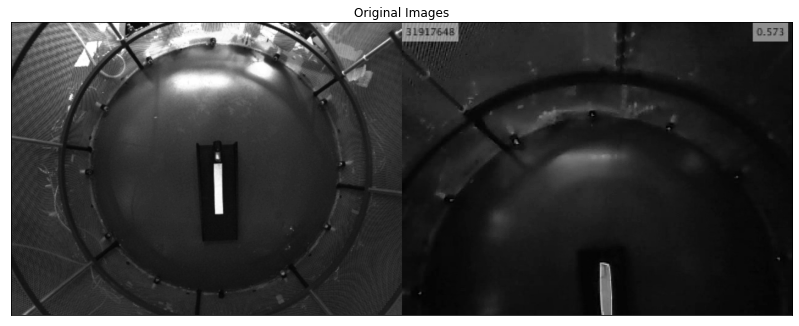

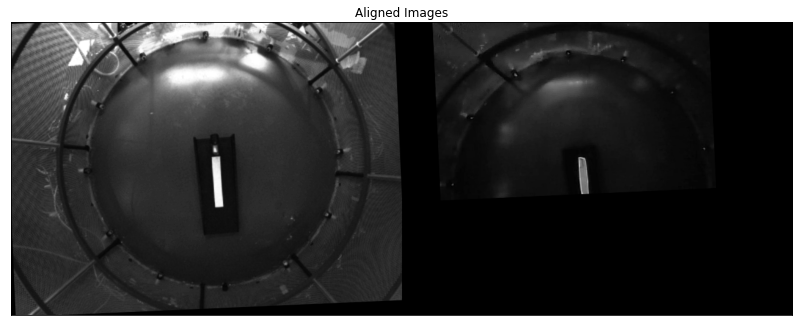

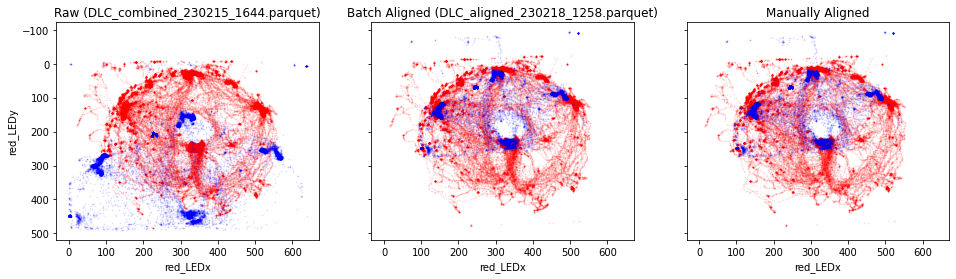

In [18]:
block_A = vid_files.iloc[1].to_dict()   # Second session in project
block_B = vid_files.iloc[-1].to_dict()  # Penultimate session in project

dirs = {
    'dlc_align': data_path / 'DLC_aligned_230218_1258.parquet',
    'dlc_raw': data_path / 'DLC_combined_230215_1644.parquet',
    'img_path': data_path / 'calibration_images'
}

make_comparison_figure(dirs, block_A, block_B)


In [ ]:
warp_mat_B = create_warp_mat(block_B)

dlc_raw_B = load_parquet(dirs['dlc_raw'], fnum=block_B['fnum'], block=block_B['block'], verbose=True)

In [ ]:
warp_mat_TEST = warp_mat_B.copy()
# warp_mat_TEST[0,2] = 1000

warp_mat_TEST[0,0] = 1 / warp_mat_TEST[0,0]
warp_mat_TEST[1,1] = 1 / warp_mat_TEST[1,1]

warp_mat_TEST[0,2] = warp_mat_TEST[0,2]
warp_mat_TEST[1,2] = -warp_mat_TEST[1,2]


print(warp_mat_TEST)

dlc_man_align_B = vtran.transform_positions_in_dataframe(dlc_raw_B.copy(), warp_mat_TEST)

fig, ax = plt.subplots(1,1, **{"figsize":(6,4)})

landmark = 'head'

dlc_raw_B.plot.scatter(x=landmark+'x', y=landmark+'y', c='m', s=0.5, alpha=0.1, ax=ax)
dlc_man_align_B.plot.scatter(x=landmark+'x', y=landmark+'y', c='g', s=0.5, alpha=0.1, ax=ax)
    
plt.show()

In [ ]:
type(dlc_raw_B)